In [1]:
#https://org-technology.com/posts/scipy-constrained-minimization-of-multivariate-scalar-functions.html
import numpy as np
from scipy.optimize import minimize

In [2]:
def f(x, sign = 1.0):
    return sign * (2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

def f_deriv(x, sign = 1.0):
    dfdx0 = sign*(-2*x[0] + 2*x[1] + 2)
    dfdx1 = sign*(2*x[0] - 4*x[1])
    return np.array([dfdx0, dfdx1])

cons = ({"type": "eq",
         "fun": lambda x: np.array([x[0]**3 - x[1]]),
         "jac": lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
       {"type": "ineq",
        "fun": lambda x: np.array([x[1] - 1]),
        "jac": lambda x: np.array([0.0, 1.0])})

## 1. 制約条件なし

In [3]:
res1 = minimize(f, [-1.0, 1.0], args = (-1.0, ), jac = f_deriv,
                method = "SLSQP") #SLSQP: 逐次最小二乗法
res1.x

array([2., 1.])

## 2. 制約条件あり

In [4]:
res2 = minimize(f, [-1.0, 1.0], args =(-1.0,), jac = f_deriv,
                constraints = cons, method = "SLSQP")
res2.x

array([1.00000009, 1.        ])

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

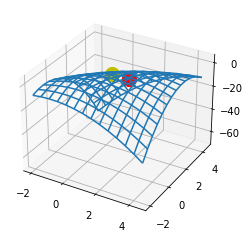

In [6]:
fig = plt.figure()
ax = fig.gca(projection = "3d")

x = np.arange(-2, 5, 0.5)
y = np.arange(-2, 5, 0.5)
xx, yy = np.meshgrid(x, y, sparse = True)
z = 2*xx*yy + 2*xx - xx**2 - 2*yy**2

ax.plot_wireframe(xx, yy, z)
ax.scatter(res1.x[0], res1.x[1], f(res2.x), s = 200, c = "r")
ax.scatter(res2.x[0], res2.x[1], f(res2.x), s = 200, c = "y")

In [7]:
#http://www.turbare.net/transl/scipy-lecture-notes/advanced/mathematical_optimization/index.html
from scipy import optimize

#### Brentの方法

In [8]:
def f(x):
    return -np.exp(-(x -0.7)**2)

x_min = optimize.brent(f)
x_min

0.6999999997839409

In [9]:
x_min-0.7

-2.160590595323697e-10

## Gradient descent(conjugate gradient descent)

In [10]:
def f(x):
    return 0.5*(1 - x[0])**2 + (x[1]-x[0]**2)**2

optimize.fmin_cg(f, [2,2])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 54
         Gradient evaluations: 18


array([0.99999639, 0.99999253])

In [11]:
def f_deriv(x):
    return np.array([-2*0.5*(1-x[0]) - 4*x[0]*(x[1] - x[0]**2),
                     2*(x[1] - x[0]**2)])

optimize.fmin_cg(f, [2,2], fprime = f_deriv)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


array([0.99999649, 0.99999274])

In [12]:
optimize.fmin_ncg(f, [2,2], fprime = f_deriv) # newton raphson & conjugate descent

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 33
         Hessian evaluations: 0


array([1., 1.])

In [13]:
def hessian(x):
    return np.array([[1-4*x[1] + 12*x[0]**2,-4*x[0]],
                    [-4*x[0], 2]])

In [14]:
optimize.fmin_ncg(f, [2,2], fprime = f_deriv, fhess = hessian)
# scipy.optimize.newton という関数もある

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 9


array([1., 1.])

In [15]:
optimize.fmin_bfgs(f, [2, 2], fprime = f_deriv) # quasi newton raphson

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9


array([1.00000582, 1.00001285])

In [16]:
optimize.fmin_l_bfgs_b(f, [2,2], fprime = f_deriv) # limitted memory BFGS

(array([1.00000005, 1.00000009]),
 1.441767747301186e-15,
 {'grad': array([ 1.02331202e-07, -2.59299369e-08]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 17,
  'nit': 16,
  'warnflag': 0})

## 重回帰分析 Y = XB + E のBを共役勾配法で推定

In [17]:
# 参考(https://aidiary.hatenablog.com/entry/20140522/1400763709)
import numpy as np

In [58]:
np.random.seed(123)
n_features = 3
n_situations = 10
X = np.random.uniform(size=(100, 3))
B_true = np.random.uniform(low=-5, high=5, size=(3,10))
E = np.random.normal(size=(100,10))
Y = X.dot(B_true) + E

In [28]:
Y.shape

(100, 10)

In [68]:
# 目的関数と勾配の定義: Percentage of Explained Variance
# 勾配の定義
def grad_B_PEV(Y, X, B):
    return -2*X.T@Y + 2*X.T@X@B    

# 目的関数の定義
def PEV(B_flattened, *args):
    Y, X, n_features, n_situations = args
    B_ = B_flattened.reshape(n_features, n_situations)
    E_est = Y - X.dot(B_)
    loss = np.trace(E_est.dot(E_est.T))#/np.trace(Y.dot(Y.T))
    grad = grad_B_PEV(Y, X, B_)
    flattened_grad = np.ravel(grad) # 行ベクトルに変換
    return loss, flattened_grad

In [69]:
B_true_flattened = np.ravel(B_true)
args = (Y, X, n_features, n_situations)
PEV(B_true_flattened, *args)

(964.797509500488,
 array([ 17.03260545, -11.14049243,  -4.43154516, -26.79903143,
         -1.3823098 ,   9.63761232,   7.96557888,  26.42708608,
          9.9195027 ,   2.54351975,  12.53756562,  -5.70389011,
         13.23248324, -10.64031321,  -0.46814572,  10.20075918,
         13.09493389,  24.68066204,  14.76964762,  -7.00813165,
          0.69009515,  -2.21292902,   3.23883778, -18.76947545,
         -3.24830317,   4.69641407,  12.34883222,  24.89815854,
         13.02904484,   0.98077097]))

In [98]:
n_features = 3
n_situations = 10

np.random.seed(123)
initial_B = np.ravel(np.random.uniform(size=(3,10)))
#initial_B = np.ravel(np.zeros((n_features,n_situations))) # 冗長な書き方。分かりやすくするため。
res = minimize(fun = PEV, x0 = initial_B, method = "CG", jac = True, #scipy.optimize.minimizeはパラメータ行列をベクトル化して利用する
        options = {"maxiter":1000, "disp":True},
        args = (Y, X, n_features, n_situations),
        tol = 1e-6
        )

Optimization terminated successfully.
         Current function value: 932.823295
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 8


In [100]:
res

     fun: 932.8232946731819
     jac: array([ 2.42152964e-11, -2.84217094e-12,  7.95807864e-12,  1.76214598e-11,
        1.75077730e-11, -1.15960574e-11,  5.38591394e-12, -1.42676981e-11,
        8.35598257e-12, -3.19744231e-14,  2.42152964e-11, -2.70006240e-12,
        7.87281351e-12,  1.79056769e-11,  1.77351467e-11, -1.18234311e-11,
        5.24380539e-12, -1.50635060e-11,  8.66862138e-12, -4.40536496e-13,
        2.56932253e-11, -2.61479727e-12,  7.56728014e-12,  1.89288585e-11,
        1.89857019e-11, -1.18234311e-11,  5.68434189e-12, -1.56887836e-11,
        9.54969437e-12, -8.24229573e-13])
 message: 'Optimization terminated successfully.'
    nfev: 8
     nit: 3
    njev: 8
  status: 0
 success: True
       x: array([-5.2966044 ,  2.53288188, -4.44412476, -3.52553308, -2.74569816,
        3.61360377, -1.26313811,  0.14273201,  0.74279141, -2.96613613,
        0.46813909,  1.62106073, -2.64829801, -1.21710844, -0.54241597,
        4.12722444,  0.67603279,  4.35476653,  0.3341940

In [101]:
B_estimated = res.x.reshape(3,10)
B_estimated

array([[-5.2966044 ,  2.53288188, -4.44412476, -3.52553308, -2.74569816,
         3.61360377, -1.26313811,  0.14273201,  0.74279141, -2.96613613],
       [ 0.46813909,  1.62106073, -2.64829801, -1.21710844, -0.54241597,
         4.12722444,  0.67603279,  4.35476653,  0.33419405,  0.40095092],
       [-4.46715088, -0.39158485,  4.35872605, -2.88634974, -4.3780013 ,
        -0.7592752 , -1.37749819,  3.48694542, -4.79764811,  4.05032298]])

In [102]:
B_true

array([[-4.83607519,  2.21184366, -4.92262486, -4.15177723, -2.7450159 ,
         3.75124534, -1.36423682,  0.39959935,  0.68103214, -2.7453664 ],
       [ 0.72146768,  1.60951795, -2.01754607, -0.81373141, -0.46911075,
         4.32350662,  0.87493747,  4.48252372,  0.56034754,  0.00561421],
       [-4.96467789, -0.19110956,  4.27454999, -3.01634311, -4.47908866,
        -0.93221107, -1.27603519,  3.57153058, -4.73388884,  4.2014923 ]])

In [104]:
## パラメータの推定誤差。今回はスカラーごとの二乗誤差の平均で評価
np.trace((B_true-B_estimated).T@(B_true - B_estimated))/30 # あんまりよくない

0.08040962718356993

In [89]:
# 誤差なしモデルの推定
Y_no_err = X@B_true

res_no_err = minimize(fun = PEV, x0 = initial_B, method = "CG", jac = True, #scipy.optimize.minimizeはパラメータ行列をベクトル化して利用する
        options = {"maxiter":1000, "disp":True},
        args = (Y_no_err, X, n_features, n_situations),
        tol = 1e-4
        )

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 8


In [106]:
np.sum((res_no_err.x-np.ravel(B_true))**2)/30 # 完璧な推定ができているため、optimize.minimizeの挙動は大丈夫っぽい

1.0868321195318552e-28

## Appendix

In [43]:
A = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
A

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [107]:
np.ravel(A) # 列方向に伸ばしていくイメージ。1行目の後ろに2行目、2行目の後ろに3行目、。。。

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [108]:
np.ravel(A).reshape((4,3))# .reshape((もとの行数, もとの列数))でnp.ravel()の逆変換ができる

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [20]:
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution

In [23]:
help(np.random.uniform)

Help on built-in function uniform:

uniform(...) method of numpy.random.mtrand.RandomState instance
    uniform(low=0.0, high=1.0, size=None)
    
    Draw samples from a uniform distribution.
    
    Samples are uniformly distributed over the half-open interval
    ``[low, high)`` (includes low, but excludes high).  In other words,
    any value within the given interval is equally likely to be drawn
    by `uniform`.
    
    .. note::
        New code should use the ``uniform`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    low : float or array_like of floats, optional
        Lower boundary of the output interval.  All values generated will be
        greater than or equal to low.  The default value is 0.
    high : float or array_like of floats
        Upper boundary of the output interval.  All values generated will be
        less than or equal to high.  The default value is 1.0.
    size 